# Multi-Modal Data Fusion - Project Work: Multi-Modal Physical Exercise Classification


In this project, real multi-modal data is studied by utilizing different techniques presented during the course. In addition, there is an optional task to try some different approaches to identify persons from the same dataset. Open MEx dataset from UCI machine learning repository is used. Idea is to apply different techniques to recognize physical exercises from wearable sensors and depth camera, user-independently.

## Description

The goal of this project is to develop user-independent pre-processing and classification models to recognize 7 different physical exercises measured by accelerometer (attached to subject's thigh) and depth camera (above the subject facing downwards recording an aerial view). All the exercises were performed subject lying down on the mat. Original dataset have also another acceleration sensor and pressure-sensitive mat, but those two modalities are ommited in this project. There are totally 30 subjects in the original dataset, and in this work subset of 10 person is utilized. Detailed description of the dataset and original data can be access in [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#). We are providing the subset of dataset in Moodle.

The project work is divided on following phases:

1. Data preparation, exploration, and visualization
2. Feature extraction and unimodal fusion for classification
3. Feature extraction and feature-level fusion for multimodal classification
4. Decision-level fusion for multimodal classification
5. Bonus task: Multimodal biometric identification of persons

where 1-4 are compulsory (max. 10 points each), and 5 is optional to get bonus points (max. 5+5 points). In each phase, you should visualize and analyse the results and document the work and findings properly by text blocks and figures between the code. <b> Nice looking </b> and <b> informative </b> notebook representing your results and analysis will be part of the grading in addition to actual implementation.

The results are validated using confusion matrices and F1 scores. F1 macro score is given as
<br>
<br>
$
\begin{equation}
F1_{macro} = \frac{1}{N} \sum_i^N F1_i,
\end{equation}
$
<br>
<br>
where $F1_i = 2  \frac{precision_i * recall_i}{precision_i + recall_i}$, and $N$ is the number of classes.
<br>

## Learning goals

After the project work, you should  

- be able to study real world multi-modal data
- be able to apply different data fusion techniques to real-world problem
- be able to evaluate the results
- be able to analyse the outcome
- be able to document your work properly

## Relevant lectures

Lectures 1-8

## Relevant exercises

Exercises 0-6

## Relevant chapters in course book

Chapter 1-14

## Additional Material

* Original dataset [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#)
* Related scientific article [MEx: Multi-modal Exercises Dataset for Human Activity Recognition](https://arxiv.org/pdf/1908.08992.pdf)

# 1. Data preparation, exploration, and visualization

<a id='task1'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 1.</b>

Download data from the Moodle's Project section. Get yourself familiar with the folder structure and data. You can read the data files using the function given below. Each file consists one exercise type performed by single user. Data are divided on multiple folders. Note that, in each folder there is one long sequence of single exercise, except exercise 4 which is performed two times in different ways. Those two sequences belongs to same class. Do the following subtasks to pre-analyse data examples and to prepare the training and testing data for next tasks:
<br>
<br>
<p> Read raw data from the files. Prepare and divide each data file to shorter sequences using windowing method. Similar to related article "MEx: Multi-modal Exercises Dataset for Human Activity Recognition", use 5 second window and 3 second overlapping between windows, producing several example sequences from one exercise file for classification purposes. Windowing is working so that starting from the beginning of each long exercise sequence, take 5 seconds of data points (from synchronized acceleration data and depth images) based on the time stamps. Next, move the window 2 seconds forward and take another 5 seconds of data. Then continue this until your are at the end of sequence. Each window will consists 500x3 matrix of acceleration data and 5x192 matrix of depth image data.</p>

</div>

In [1]:
!gdown https://drive.google.com/uc?id=1XcZynRgcIUiCK5N5g7hBXPWYW3y94djA
!unzip MEx.zip

Downloading...
From: https://drive.google.com/uc?id=1XcZynRgcIUiCK5N5g7hBXPWYW3y94djA
To: /content/MEx.zip

  0% 0.00/4.49M [00:00<?, ?B/s]
 12% 524k/4.49M [00:00<00:00, 5.12MB/s]
100% 4.49M/4.49M [00:00<00:00, 25.1MB/s]
Archive:  MEx.zip
   creating: MEx/act/
   creating: MEx/act/01/
  inflating: MEx/act/01/act_01_exercise_01_1.csv  
  inflating: MEx/act/01/act_01_exercise_02_1.csv  
  inflating: MEx/act/01/act_01_exercise_03_1.csv  
  inflating: MEx/act/01/act_01_exercise_04_1.csv  
  inflating: MEx/act/01/act_01_exercise_04_2.csv  
  inflating: MEx/act/01/act_01_exercise_05_1.csv  
  inflating: MEx/act/01/act_01_exercise_06_1.csv  
  inflating: MEx/act/01/act_01_exercise_07_1.csv  
   creating: MEx/act/02/
  inflating: MEx/act/02/act_02_exercise_01_1.csv  
  inflating: MEx/act/02/act_02_exercise_02_1.csv  
  inflating: MEx/act/02/act_02_exercise_03_1.csv  
  inflating: MEx/act/02/act_02_exercise_04_1.csv  
  inflating: MEx/act/02/act_02_exercise_04_2.csv  
  inflating: MEx/act/02/ac

In [1]:
# Import relevant libraries here
from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd

# Enter data folder location
loc = "./MEx"

In [2]:
"""
    IMPORTANT: PLEASE DO NOT MODIFY THE CODE IN THIS CELL.
"""
def path_to_meta(p):
    meta = dict()
    meta["subject_id"] = p.parent.stem
    meta["exercise_id"] = p.stem.split("_")[-2]
    meta["trial"] = int(p.stem.split("_")[-1])
    meta["sensor_code"] = p.stem.split("_")[0]
    meta["sensor"] = {"act": "acc", "dc": "dc"}[meta["sensor_code"]]
    return meta

# Find, read, and compose the measurements
paths_record = Path(loc).glob("*/*/*.csv")

records = []

for path_record in paths_record:
    df = pd.read_csv(path_record, delimiter=",", header=None)
    meta = path_to_meta(path_record)

    if meta["sensor"] == "acc":
        col_names = ["time", "acc_0", "acc_1", "acc_2"]
        df.columns = col_names
    else:
        num_cols = df.shape[1]
        col_names = ["time", ] + [f"dc_{i}" for i in range(num_cols-1)]
        df.columns = col_names

    meta["df"] = df

    records.append(meta)

df_records = pd.DataFrame.from_records(records)

print(f"Total records found: {len(df_records)}")
print("Dataframe with all records:")
display(df_records.head())
print("Dataframe with one measurement series:")
display(df_records["df"].iloc[0].head())

Total records found: 160
Dataframe with all records:


,subject_id,exercise_id,trial,sensor_code,sensor,df
0,01,01,1,act,acc,time acc_0 acc_1 acc_2 0 ...
1,01,02,1,act,acc,time acc_0 acc_1 acc_2 0 ...
2,01,03,1,act,acc,time acc_0 acc_1 acc_2 0 ...
3,01,04,1,act,acc,time acc_0 acc_1 acc_2 0 ...
4,01,04,2,act,acc,time acc_0 acc_1 acc_2 0 ...


Dataframe with one measurement series:


,time,acc_0,acc_1,acc_2
0,0.0,-0.515625,-0.843750,-0.131944
1,10.0,-0.515625,-0.853125,-0.134375
2,20.0,-0.515625,-0.850000,-0.140625
3,30.0,-0.515625,-0.862500,-0.150000
4,40.0,-0.525000,-0.856250,-0.156250


In [3]:
"""
    IMPORTANT: PLEASE DO NOT MODIFY THE CODE IN THIS CELL.
"""

# Extract 5-second long windows with 2-second shift (3-second overlap)

records_windowed = []

time_window = 5000.
time_offset = 2000.

for row_idx, row_data in df_records.iterrows():
    df_tmp = row_data["df"]
    time_start = np.min(df_tmp["time"].to_numpy())
    time_end = np.max(df_tmp["time"].to_numpy())

    for window_idx, t0 in enumerate(np.arange(time_start, time_end, time_offset)):
        t1 = t0 + time_window
        # Handle boundary conditions - skip the measurements from the end shorter than window size
        if t1 > time_end:
            continue

        tmp_data = deepcopy(row_data)
        tmp_data["window_idx"] = window_idx
        tmp_data["df"] = df_tmp[(df_tmp["time"] >= t0) &
                                (df_tmp["time"] < t1)].copy()

        records_windowed.append(tmp_data)

df_records_windowed = pd.DataFrame.from_records(records_windowed)

print(f"Total windows extracted: {len(df_records_windowed)}")
print("Dataframe with all windowed records:")
display(df_records_windowed.head())
print("Dataframe with one windowed measurement series:")
display(df_records_windowed["df"].iloc[0].head())

Total windows extracted: 4169
Dataframe with all windowed records:


,subject_id,exercise_id,trial,sensor_code,sensor,df,window_idx
0,01,01,1,act,acc,time acc_0 acc_1 acc_2 0 ...,0
1,01,01,1,act,acc,time acc_0 acc_1 acc_2 200 ...,1
2,01,01,1,act,acc,time acc_0 acc_1 acc_2 400 ...,2
3,01,01,1,act,acc,time acc_0 acc_1 acc_2 60...,3
4,01,01,1,act,acc,time acc_0 acc_1 acc_2 80...,4


Dataframe with one windowed measurement series:


,time,acc_0,acc_1,acc_2
0,0.0,-0.515625,-0.843750,-0.131944
1,10.0,-0.515625,-0.853125,-0.134375
2,20.0,-0.515625,-0.850000,-0.140625
3,30.0,-0.515625,-0.862500,-0.150000
4,40.0,-0.525000,-0.856250,-0.156250


<a id='task1'></a>
<div class=" alert alert-warning">
     
<p> <b>1.1</b> Plot few examples of prepared data for each modalities (accelometer and depth camera). Plot acceleration sensor as multi-dimensional time-series and depth camera data as 2D image. Plot 5 second acceleration sensor and depth image sequences of person 1 and 5 performing exercises 2, 5, and 6. Take the first windowed example from the long exercise sequence. </p>

</div>

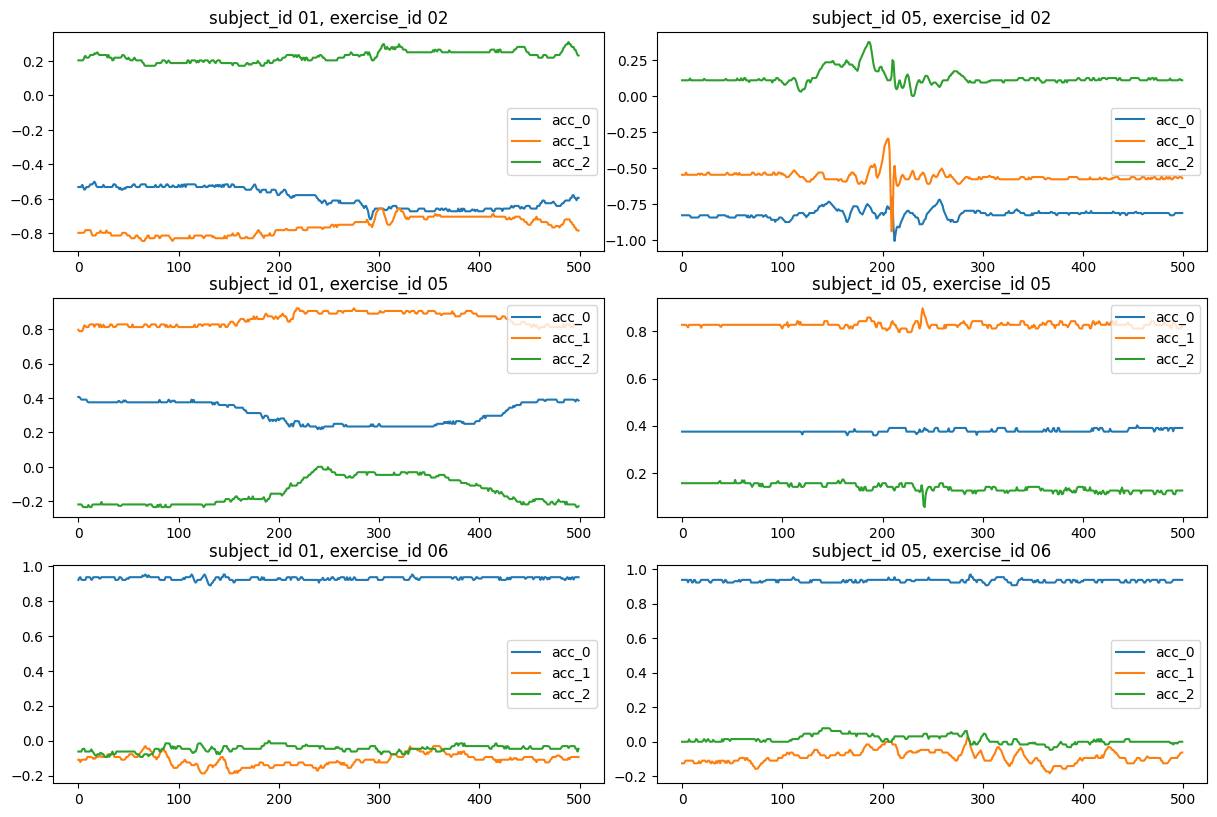

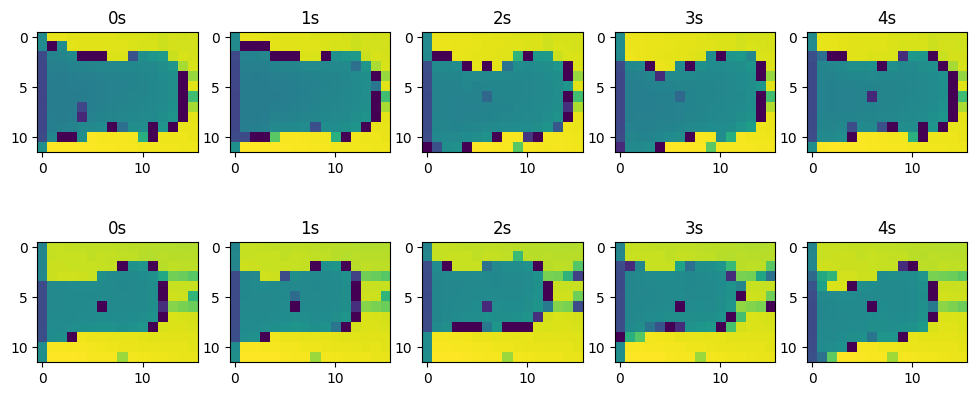

In [41]:
# 1.1. Visualize selected samples for both modalities

### Your code begins here ###
import matplotlib.pyplot as plt

#Extract sensor data for [sensor, person, exercise]
def extract_data(sensor, subject_id, exercise_id):
    data = df_records_windowed[(df_records_windowed['sensor']==sensor)&(df_records_windowed['subject_id']==subject_id)&(df_records_windowed['exercise_id']==exercise_id)]
    return data

#Plotting acceleration sensor data
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(12,8))
fig.tight_layout(pad=2.0)
for i, person in enumerate(['01','05']):
    for j, exercise in enumerate(['02','05','06']):
        subject_acc = extract_data('acc', person, exercise).iloc[0]
        subject_acc['df'][['acc_0','acc_1','acc_2']].plot(ax=axes[j,i], title = "subject_id "+person+", exercise_id "+exercise)


#Plotting depth image data
fig2, axes2 = plt.subplots(nrows=2, ncols=5,figsize=(12,5))
fig.tight_layout(pad=0.1)
for t in range(5):
    for i, person in enumerate(['01','05']):
        subject_dc = extract_data('dc', person, exercise).iloc[0]
        frame_row = subject_dc['df'].drop('time', axis=1).iloc[t].values
        frame = np.array(frame_row).reshape(12, 16)
        axes2[i, t].imshow(frame, cmap='viridis')
        axes2[i, t].set_title(str(t)+"s")
### Your code ends here ###

<a id='task1'></a>
<div class=" alert alert-warning">

<p> <b>1.2</b> Split the prepared dataset to training and testing datasets so that data of persons 1-7 are used for training and data of persons 8-10 are used for testing. In next tasks, training dataset could be further divided on (multiple) validation data folds to tune the models parameters, when needed.<br>
    
<p> Note: Training set should have 1486 windows and testing set should have 598 windows. In training set, acceleration data will have a window without a pair with depth camera data, that window should be dropped as it doesn't have a pair.<p>
  
Document your work, calculate the indicator statistics of training and testing datasets (number of examples, dimensions of each example) and visualize prepared examples.

</div>

In [4]:
# 1.2. Split samples based on subject ID into training and testing datasets for futher experiments

### Your code begins here ###

#Train test split sensor data
def train_test_split(sensor):
    data_filtered = df_records_windowed[(df_records_windowed['sensor']==sensor)]
    data = data_filtered.copy()

    for i in range(len(data['df'])):
        data['df'].iloc[i].drop('time', axis=1, inplace=True)

    test = data[(data['subject_id']=='08')|(data['subject_id']=='09')|(data['subject_id']=='10')]
    train = data[~((data['subject_id']=='08')|(data['subject_id']=='09')|(data['subject_id']=='10'))]
    return train, test

acc_train, acc_test = train_test_split('acc')
dc_train, dc_test = train_test_split('dc')
### Your code ends here ###

# 2. Feature extraction and fusion for unimodal classification

<a id='task2'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 2.</b>

Use the training dataset prepared in task 1. to build models based on the combination of principal component analysis (PCA), linear discriminant analysis (LDA), and nearest neighbour (NN) classifier for each modality separately and evaluate the model on test dataset. Do the subtasks given as
<br>
<br>
<p> <b>2.1</b> Calculate PCA and LDA transformations to reduce the dimensionality of accelerometer data (e.g., using scikit-learn implementations). Before transformations downsample data from 100 Hz to 25 Hz (using scipy.signal.resample) to get 125x3 matrix of data for each 5 sec window. You should also standardize the values to zero mean and unit variance before the transformations. Using training dataset, fit PCA with 5-dimensional subspace (i.e., choosing the 5 largest principal components) and fit LDA with 5-dimensional subspace. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 3x(5+5). Perform the fusion of PCA and LDA similar manner as presented in Lecture 3 (pages 24-25) using NN method. Evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>

Note: Standardize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes (The expected F1 score for this task should generally fall within the range of 40 to 50)
    
</div>

In [5]:
# 2.1

### Your code begins here ###
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from scipy import signal

scaler = StandardScaler()
### Your code ends here ###

In [44]:

#Resample accelerometer data to create 125x3 matrix
def resample_acc_data(data):
    dfs = []
    for i in range(len(data)):
        resampled = signal.resample(data['df'].iloc[i], 125)
        resampled = resampled.reshape(3, 125)
        resampled_std_df = pd.DataFrame(scaler.fit_transform(resampled))
        resampled_std_df['exercise_id'] = data.iloc[i]['exercise_id']
        dfs.append(resampled_std_df)
    return pd.concat(dfs, ignore_index=True)

#Resample train and test accelerometer data
acc_train_data = resample_acc_data(acc_train)
acc_test_data = resample_acc_data(acc_test)

In [45]:
#Principal component analysis (PCA) for accelerometer data
pca = PCA(n_components = 5)
pca_train = pca.fit_transform(acc_train_data.drop('exercise_id', axis=1))
components = pca.components_
pca_test = pca.transform(acc_test_data.drop('exercise_id', axis=1))

#Linear discriminant analysis (LDA) for accelerometer data
lda = LinearDiscriminantAnalysis(n_components = 5)
lda_train = lda.fit_transform(acc_train_data.drop('exercise_id', axis=1), acc_train_data['exercise_id'])
lda_test = lda.transform(acc_test_data.drop('exercise_id', axis=1))

In [46]:
#Combine acc_0, acc_1, acc_2 accelerometer data into one vector
def fuse_acc_data(data):
    fused_rows = []
    for i in range(0, len(data), 3):
        fused_rows.append(list(data[i]) + list(data[i+1]) + list(data[i+2]))
    return fused_rows

pca_train_fused = fuse_acc_data(pca_train)
pca_test_fused = fuse_acc_data(pca_test)

lda_train_fused = fuse_acc_data(lda_train)
lda_test_fused = fuse_acc_data(lda_test)

#Extract train and test labels
train_labels = acc_train['exercise_id']
test_labels = acc_test['exercise_id']

In [47]:
from sklearn.preprocessing import minmax_scale

#PCA and LDA fusion
def calc_res(train, test):
    res = []
    for i in range(len(test)):
        r = np.power(np.array(test[i]) - np.array(train), 2)
        res.append(np.sum(r, axis = 1))
    return res

pca_res = calc_res(pca_train_fused, pca_test_fused)
lda_res = calc_res(lda_train_fused, lda_test_fused)

pca_norm = minmax_scale(pca_res, feature_range=(0, 1), axis= 1, copy=True)
lda_norm = minmax_scale(lda_res, feature_range=(0, 1), axis= 1, copy=True)

pca_norm = pd.DataFrame(pca_norm)
lda_norm = pd.DataFrame(lda_norm)

lda_pca = pd.DataFrame(pca_norm)
lda_pca = (pca_norm + lda_norm) / 2

F1 score:  0.391304347826087
F1 score:  0.3849781383969647
F1 score:  0.38301668968106417
Confusion matrix: 



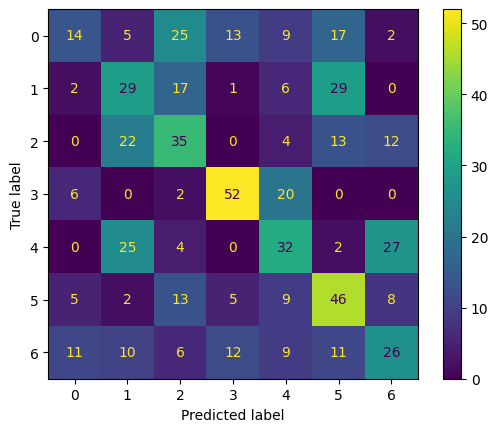

In [48]:
#Nearest neighbour (NN) classifier for accelerometer data

target_pca_lda = []
label_pca_lda = []

for i in range(len(lda_pca)):
  t = np.argmin(lda_pca.iloc[i])
  target_pca_lda.append(train_labels.iloc[t])
  label_pca_lda.append(test_labels.iloc[i])

label = pd.DataFrame(label_pca_lda)
target = pd.DataFrame(target_pca_lda)

print("F1 score: ", metrics.f1_score(label, target, average='micro'))
print("F1 score: ", metrics.f1_score(label, target, average='macro'))
print("F1 score: ", metrics.f1_score(label, target, average='weighted'))
print("Confusion matrix: \n", )
cm = metrics.confusion_matrix(label, target)
metrics.ConfusionMatrixDisplay(cm).plot()

<a id='task2'></a>
<div class=" alert alert-warning">
<p> <b>2.2</b> Use PCA and LDA transformations to reduce the dimensionality of depth images. You should also standardize the values to zero mean and unit variance before the transformations. Fit PCA and LDA for all training images (12x16, 192-dimensional in vectorized form) by choosing 5-dimensional subspace for both PCA and LDA. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 5x1x(5+5). Similar to task 2.1, do the PCA and LDA fusion using NN and evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>

Note: Standardize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes (The expected F1 score for this task should generally fall within the range of 40 to 50)
    
</div>

In [49]:
# 2.2

### Your code begins here ###

#Resample depth images data
def resample_dc_data(data):
    dfs = []
    for i in range(len(data)):
        df = data['df'].iloc[i]
        std_df = pd.DataFrame(scaler.fit_transform(df))
        std_df['exercise_id'] = data.iloc[i]['exercise_id']
        dfs.append(std_df)
    return pd.concat(dfs, ignore_index=True)

dc_train_data = resample_dc_data(dc_train)
dc_test_data = resample_dc_data(dc_test)
### Your code ends here ###

In [50]:

#Principal component analysis (PCA) for depth images data
pca = PCA(n_components = 5)
pca_train = pca.fit_transform(dc_train_data.drop('exercise_id', axis=1))
components = pca.components_
pca_test = pca.transform(dc_test_data.drop('exercise_id', axis=1))

#Linear discriminant analysis (LDA) for depth images data
lda = LinearDiscriminantAnalysis(n_components = 5)
lda_train = lda.fit_transform(dc_train_data.drop('exercise_id', axis=1), dc_train_data['exercise_id'])
lda_test = lda.transform(dc_test_data.drop('exercise_id', axis=1))

In [51]:
#Combine depth image each sequence data into one vector
def fuse_dc_data(data):
    fused_rows = []
    for i in range(0, len(data), 5):
        fused_rows.append(list(data[i]) + list(data[i+1]) + list(data[i+2]) + list(data[i+3]) + list(data[i+4]))
    return fused_rows

pca_train_fused = fuse_dc_data(pca_train)
pca_test_fused = fuse_dc_data(pca_test)

lda_train_fused = fuse_dc_data(lda_train)
lda_test_fused = fuse_dc_data(lda_test)

#Extract train and test labels
train_labels = dc_train['exercise_id']
test_labels = dc_test['exercise_id']

In [52]:
#PCA and LAD fusion
pca_res = calc_res(pca_train_fused, pca_test_fused)
lda_res = calc_res(lda_train_fused, lda_test_fused)

pca_norm = minmax_scale(pca_res, feature_range=(0, 1), axis= 1, copy=True)
lda_norm = minmax_scale(lda_res, feature_range=(0, 1), axis= 1, copy=True)

pca_norm = pd.DataFrame(pca_norm)
lda_norm = pd.DataFrame(lda_norm)

lda_pca = pd.DataFrame(pca_norm)
lda_pca = (pca_norm + lda_norm) / 2

F1 score:  [0.6442953  0.47368421 0.31111111 0.44019139 0.60540541 0.1981982
 0.2992126 ]
F1 score (micro):  0.43478260869565216
F1 score (macro):  0.4245854590342084
F1 score (weighted):  0.42455926372869796
Confusion matrix: 



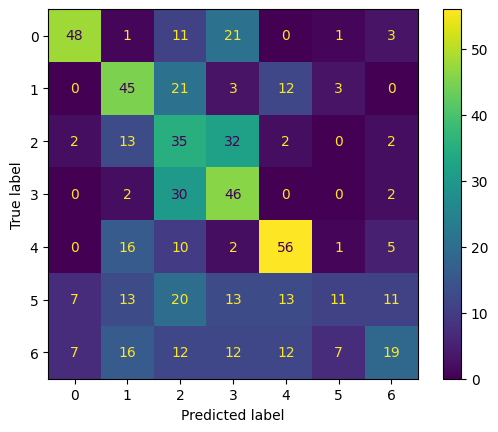

In [53]:
#Nearest neighbour (NN) classifier for depth image
target_pca_lda = []
label_pca_lda = []

for i in range(len(lda_pca)):
  t = np.argmin(lda_pca.iloc[i])
  target_pca_lda.append(train_labels.iloc[t])
  label_pca_lda.append(test_labels.iloc[i])

label = pd.DataFrame(label_pca_lda)
target = pd.DataFrame(target_pca_lda)

print("F1 score: ", metrics.f1_score(label, target, average=None))
print("F1 score (micro): ", metrics.f1_score(label, target, average='micro'))
print("F1 score (macro): ", metrics.f1_score(label, target, average='macro'))
print("F1 score (weighted): ", metrics.f1_score(label, target, average='weighted'))
print("Confusion matrix: \n", )
cm = metrics.confusion_matrix(label, target)
metrics.ConfusionMatrixDisplay(cm).plot()

# 3. Feature extraction and feature-level fusion for multimodal classification

<a id='task3'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 3.</b>

Prepare new feature sets for each modality and combine them to single feature representation. Compare two classifiers from scikit-learn. Train classifiers using joint feature presentation. Evaluate and compare the result using testing dataset. Do the subtasks given as
<br>   

<p> <b>3.1</b> Similar to task 2.1, calculate PCA for accelerometer, but choose now the 10 largest principal components as 10-dim feature vector for each window. In addition, for each window calculate mean and standard deviation of each three acc channels as statistical features, resulting 6-dimensional vector. Combine these to 36-dimensional final feature vector.</p>

Document your work.
    
</div>

In [54]:
# 3.1

### Your code begins here ###

#Principal component analysis (PCA) for accelerometer data
pca = PCA(n_components = 10)
pca_train = pca.fit_transform(acc_train_data.drop('exercise_id', axis=1))
components = pca.components_
pca_test = pca.transform(acc_test_data.drop('exercise_id', axis=1))

#Combine acc_0, acc_1, acc_2 accelerometer data into one vector
def fuse_acc_data(data):
    fused_rows = []
    for i in range(0, len(data), 3):
        fused_rows.append(list(data[i]) + list(data[i+1]) + list(data[i+2]))
    return fused_rows

#Add mean and std to feature vector
def add_mean_std(pca, original_data):
    mean = np.mean(original_data.drop('exercise_id', axis=1), axis=1)
    std = np.std(original_data.drop('exercise_id', axis=1), axis=1)

    pca = np.insert(pca, -1, mean.values, axis=1)
    pca = np.insert(pca, -1, std.values, axis=1)

    return pca

pca_train_mean_std = add_mean_std(pca_train, acc_train_data)
pca_test_mean_std = add_mean_std(pca_test, acc_test_data)

pca_train_fused_acc = fuse_acc_data(pca_train_mean_std)
pca_test_fused_acc = fuse_acc_data(pca_test_mean_std)


### Your code ends here ###

<a id='task3'></a>
<div class=" alert alert-warning">

<p> <b>3.2</b> Similar to task 2.2, calculate the PCA for depth images using same setup, but now choose the 10 largest principal components as feature vector. Concatenate the image sequence forming 50-dimensional feature vector from each windowed example.</p>

Document your work.
    
</div>

In [55]:
# 3.2

### Your code begins here ###
#Principal component analysis (PCA) for depth images data
pca = PCA(n_components = 10)
pca_train = pca.fit_transform(dc_train_data.drop('exercise_id', axis=1))
components = pca.components_
pca_test = pca.transform(dc_test_data.drop('exercise_id', axis=1))

#Combine depth image each sequence data into one vector
def fuse_dc_data(data):
    fused_rows = []
    for i in range(0, len(data), 5):
        fused_rows.append(list(data[i]) + list(data[i+1]) + list(data[i+2]) + list(data[i+3]) + list(data[i+4]))
    return fused_rows

pca_train_fused_dc = fuse_dc_data(pca_train)
pca_test_fused_dc = fuse_dc_data(pca_test)

### Your code ends here ###

<a id='task3'></a>
<div class=" alert alert-warning">

<p> <b>3.3</b> Form a joint feature presentation of features extracted in 3.1 and 3.2, resulting 86-dimensional feature vector for each example. Normalize data between 0-1 using the training dataset. Use support vector machine (SVM) with RBF-kernel and Gaussian naiveBayes classifier (use default parameter values for both classifiers). Train the classifiers and evaluate and compare classifiers on testset using confusion matrices and F1 scores.</p>

Note: Normalize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes. (The expected F1 score for this task should generally fall within the range of 55 to 70)
    
</div>

In [56]:
# 3.3

### Your code begins here ###

from sklearn.preprocessing import minmax_scale

#Combine accelerometer PCA and depth image PCA into one vector
def combine_pca_acc_dc(pca_acc, pca_dc):
    pca_acc_dc = [ pca_acc[i]+pca_dc[i] for i in range(len(pca_acc))]
    return pca_acc_dc

#Accelerometer PCA and depth image PCA fusion
pca_train_fused_acc_dc = combine_pca_acc_dc(pca_train_fused_acc[:-1], pca_train_fused_dc)
pca_test_fused_acc_dc = combine_pca_acc_dc(pca_test_fused_acc, pca_test_fused_dc)

#MIn max scale
pca_train_norm = minmax_scale(pca_train_fused_acc_dc, feature_range=(0, 1), axis=1, copy=True)
pca_test_norm = minmax_scale(pca_test_fused_acc_dc, feature_range=(0, 1), axis=1, copy=True)

#Extract train and test lables
train_labels_dc = dc_train['exercise_id']
test_labels_dc = dc_test['exercise_id']

### Your code ends here ###

F1 score:  [0.12389381 0.39759036 0.37777778 0.5326087  0.63959391 0.57317073
 0.26041667]
F1 score (micro):  0.431438127090301
F1 score (macro):  0.41500742102698496
F1 score (weighted):  0.4166622762331042
Confusion matrix: 



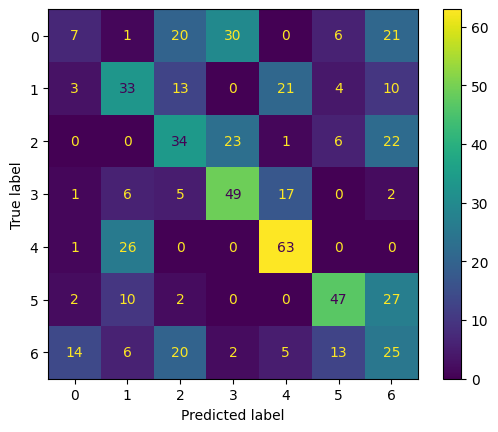

In [57]:
#Support vector machine (SVM) classifier

from sklearn.svm import SVC
clf = SVC(kernel='rbf')
clf.fit(pca_train_norm, train_labels_dc)

predicted = clf.predict(pca_test_norm)

print("F1 score: ", metrics.f1_score(test_labels_dc, predicted,average=None))
print("F1 score (micro): ", metrics.f1_score(test_labels_dc, predicted, average='micro'))
print("F1 score (macro): ", metrics.f1_score(test_labels_dc, predicted, average='macro'))
print("F1 score (weighted): ", metrics.f1_score(test_labels_dc, predicted, average='weighted'))
print("Confusion matrix: \n", )
confusion_matrix = metrics.confusion_matrix(test_labels_dc, predicted)
metrics.ConfusionMatrixDisplay(confusion_matrix).plot()

F1 score:  [0.21176471 0.13793103 0.07058824 0.19387755 0.37037037 0.09859155
 0.33846154]
F1 score (micro):  0.21237458193979933
F1 score (macro):  0.20308356925818868
F1 score (weighted):  0.20392244089309491
Confusion matrix: 



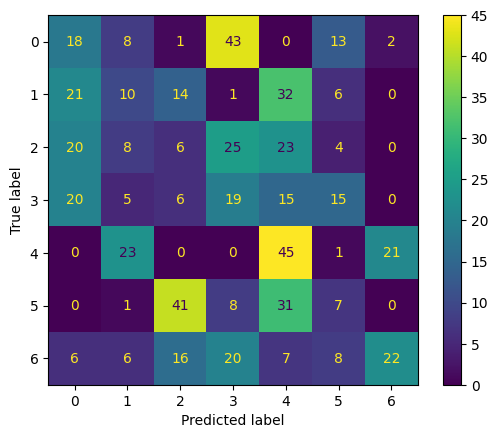

In [58]:
#Gaussian naiveBayes classifier
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(pca_train_norm, np.ravel(train_labels_dc))

predicted= gnb.predict(pca_test_norm)

print("F1 score: ", metrics.f1_score(test_labels_dc,predicted,average=None))
print("F1 score (micro): ", metrics.f1_score(test_labels_dc, predicted, average='micro'))
print("F1 score (macro): ", metrics.f1_score(test_labels_dc, predicted, average='macro'))
print("F1 score (weighted): ", metrics.f1_score(test_labels_dc, predicted, average='weighted'))
print("Confusion matrix: \n", )
confusion_matrix = metrics.confusion_matrix(test_labels_dc,predicted)
metrics.ConfusionMatrixDisplay(confusion_matrix).plot()

# 4. Decision-level fusion for multimodal classification

<a id='task4'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 4.</b>

Use features calculated for each modality in task 3. Choose base classifier for each modality from scikit-learn. Train classifiers for each modality feature presentations separately and combine the outputs in decision level. Evaluate and compare the result on testing dataset. Do the subtasks given as
<br>
<br>
<p> <b>4.1</b> Use base classifiers of support vector machine (SVM) with RBF-kernel and AdaBoost classifier (with random_state=0).
Normalize data between 0-1 using the training dataset. Train the base classifiers by tuning the model parameters (<i>C</i> parameter and RBF-kernel <i>gamma</i> in SVM as well as <i>n_estimators</i> and <i>learning_rate</i> in Adaboost) using 10-fold cross-validation on training dataset to find optimal set of parameters (hint: use GridSearchCV from scikit-learn). For grid search use the following values $C = [0.1, 1.0, 10.0, 100.0]$, $gamma=[0.1, 0.25, 0.5, 0.75, 1.0, 2.0]$, $n\_estimators = [50, 100, 500, 1000]$, and $learning\_rate = [0.1, 0.25, 0.5, 0.75,1.0]$.<br>
Choose the best parameters and train the classifiers for each modality on whole training dataset. Is there a possibility that classifiers will overfit to training data using this parameter selection strategy? If so, why? </p>

Note: Normalize the data along each axis.
<br>

Document your work, answer the given question, evaluate the results, and analyse the outcomes.
    
</div>

In [59]:
# 4.1

### Your code begins here ###
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# normalization
pca_train_fused_acc_norm = minmax_scale(pca_train_fused_acc[:-1], feature_range=(0, 1), axis=1, copy=True)
# print(pca_train_fused_acc_norm.shape)
pca_test_fused_acc_norm = minmax_scale(pca_test_fused_acc, feature_range=(0, 1), axis=1, copy=True)
# print(pca_test_fused_acc_norm.shape)
pca_train_fused_dc_norm = minmax_scale(pca_train_fused_dc, feature_range=(0, 1), axis=1, copy=True)
# print(pca_train_fused_dc_norm.shape)
pca_test_fused_dc_norm = minmax_scale(pca_test_fused_dc, feature_range=(0, 1), axis=1, copy=True)
# print(pca_test_fused_dc_norm.shape)

train_labels = le.fit_transform(dc_train['exercise_id'])
# print(train_labels.shape)
test_labels = le.fit_transform(dc_test['exercise_id'])
# print(train_labels.shape)

# Define the parameter grid for SVM and AdaBoost
svm_params = {
    'C': [0.1, 1.0, 10.0, 100.0],
    'gamma': [0.1, 0.25, 0.5, 0.75, 1.0, 2.0]
}
adaboost_params = {
    'n_estimators': [50, 100, 500, 1000],
    'learning_rate': [0.1, 0.25, 0.5, 0.75, 1.0]
}

# Initialize the classifiers
svm = SVC(kernel='rbf', probability=True, random_state=0)
adaboost = AdaBoostClassifier(random_state=0)

# Create GridSearchCV objects
svm_grid_acc = GridSearchCV(svm, svm_params, cv=10, scoring='f1_macro')
svm_grid_dc = GridSearchCV(svm, svm_params, cv=10, scoring='f1_macro')
adaboost_grid_acc = GridSearchCV(adaboost, adaboost_params, cv=10, scoring='f1_macro')
adaboost_grid_dc = GridSearchCV(adaboost, adaboost_params, cv=10, scoring='f1_macro')

print("Training SVM classifier...")
# Train the SVM classifier on acc
svm_grid_acc.fit(pca_train_fused_acc_norm, train_labels)
print("Best SVM parameters acc:", svm_grid_acc.best_params_)
svm_best_acc = svm_grid_acc.best_estimator_

# Train the SVM classifier on dc
svm_grid_dc.fit(pca_train_fused_dc_norm, train_labels)
print("Best SVM parameters dc:", svm_grid_dc.best_params_)
svm_best_dc = svm_grid_dc.best_estimator_

print("Training AdaBoost classifier...")
# Train the AdaBoost classifier on acc
adaboost_grid_acc.fit(pca_train_fused_acc_norm, train_labels)
print("Best AdaBoost parameters acc:", adaboost_grid_acc.best_params_)
adaboost_best_acc = adaboost_grid_acc.best_estimator_

# Train the AdaBoost classifier on dc
adaboost_grid_dc.fit(pca_train_fused_dc_norm, train_labels)
print("Best AdaBoost parameters- acc:", adaboost_grid_dc.best_params_)
adaboost_best_dc = adaboost_grid_dc.best_estimator_

### Your code ends here ###

Training SVM classifier...
Best SVM parameters acc: {'C': 100.0, 'gamma': 2.0}
Best SVM parameters dc: {'C': 10.0, 'gamma': 0.75}
Training AdaBoost classifier...
Best AdaBoost parameters acc: {'learning_rate': 0.75, 'n_estimators': 500}
Best AdaBoost parameters- acc: {'learning_rate': 0.75, 'n_estimators': 1000}


<a id='task4'></a>
<div class=" alert alert-warning">


<p> <b>4.2</b> Predict probabilistic outputs of each trained classifier for both modalities using the test set. </p>
<br>
Document your work, evaluate the results, and analyse the outcomes.
    
</div>


SVM Classifier Evaluation acc
F1 Score: 0.38940111702755337
Confusion Matrix:


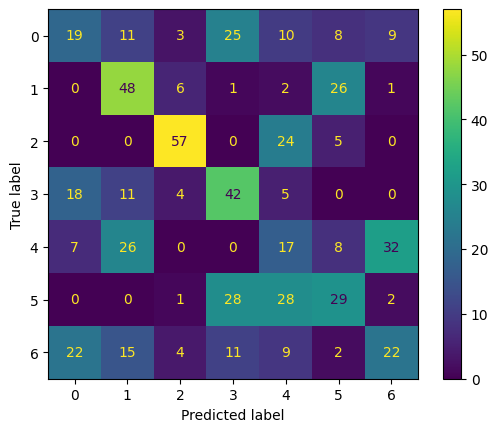

In [60]:
# 4.2

### Your code begins here ###
# probabilities
svm_acc_probs = svm_best_acc.predict_proba(pca_test_fused_acc_norm)
svm_dc_probs = svm_best_dc.predict_proba(pca_test_fused_dc_norm)
adaboost_acc_probs = adaboost_best_acc.predict_proba(pca_test_fused_acc_norm)
adaboost_dc_probs = adaboost_best_dc.predict_proba(pca_test_fused_dc_norm)

# Evaluate the classifiers on the test set
svm_predictions_ac = svm_best_acc.predict(pca_test_fused_acc_norm)
svm_predictions_dc = svm_best_dc.predict(pca_test_fused_dc_norm)
adaboost_predictions_ac = adaboost_best_acc.predict(pca_test_fused_acc_norm)
adaboost_predictions_dc = adaboost_best_dc.predict(pca_test_fused_dc_norm)

print("\nSVM Classifier Evaluation acc")
print("F1 Score:", metrics.f1_score(test_labels, svm_predictions_ac, average='macro'))
print("Confusion Matrix:")
disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(test_labels, svm_predictions_ac))
disp.plot()

### Your code ends here ###


SVM Classifier Evaluation dc
F1 Score: 0.7393684820432636
Confusion Matrix:


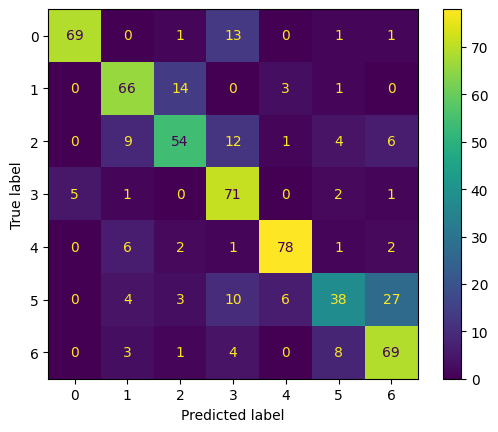

In [67]:
print("\nSVM Classifier Evaluation dc")
print("F1 Score:", metrics.f1_score(test_labels, svm_predictions_dc, average='macro'))
print("Confusion Matrix:")
disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(test_labels, svm_predictions_dc))
disp.plot()


AdaBoost Classifier Evaluation acc
F1 Score: 0.2507720376929012
Confusion Matrix:


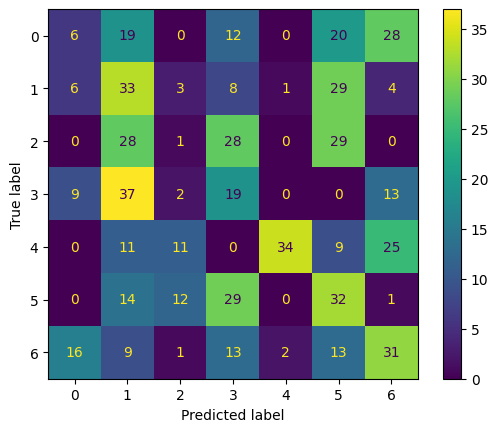

In [68]:
print("\nAdaBoost Classifier Evaluation acc")
print("F1 Score:", metrics.f1_score(test_labels, adaboost_predictions_ac, average='macro'))
print("Confusion Matrix:")
disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(test_labels, adaboost_predictions_ac))
disp.plot()


AdaBoost Classifier Evaluation dc
F1 Score: 0.3984765503982368
Confusion Matrix:


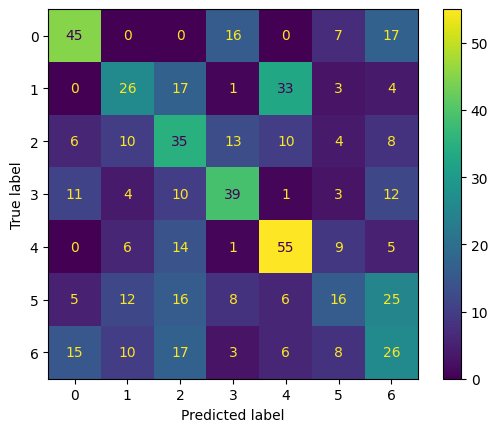

In [69]:
print("\nAdaBoost Classifier Evaluation dc")
print("F1 Score:", metrics.f1_score(test_labels, adaboost_predictions_dc, average='macro'))
print("Confusion Matrix:")
disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(test_labels, adaboost_predictions_dc))
disp.plot()

<a id='task4'></a>
<div class=" alert alert-warning">
<p> <b>4.3</b> Combine the probabilistic outputs of different modalities by fixed classification rules: max, min, prod, and sum. Evaluate, compare, and analyse the final combined results using confusion matrices and F1 scores. Show results for each base classifier combinations (i.e., $SVM_{acc}+SVM_{depth}$, $AdaBoost_{acc}+AdaBoost_{depth}$, $SVM_{acc}+AdaBoost_{depth}$, $AdaBoost_{acc}+SVM_{depth}$)</p>
<br>
Document your work, evaluate the results, and analyse the outcomes.
    
</div>

--- SVMacc+SVMdepth ---
Rule: max, F1 Score (macro): 0.6892602093996546
Rule: prod, F1 Score (macro): 0.6928209484796725
Rule: sum, F1 Score (macro): 0.698178956838123
--- AdaBoostacc+AdaBoostdepth ---
Rule: max, F1 Score (macro): 0.33670482595672124
Rule: prod, F1 Score (macro): 0.38919484956494815
Rule: sum, F1 Score (macro): 0.3874620743018006
--- SVMacc+AdaBoostdepth ---
Rule: max, F1 Score (macro): 0.4101631364853005
Rule: prod, F1 Score (macro): 0.43101872340597513
Rule: sum, F1 Score (macro): 0.42821076193008734
--- AdaBoostacc+SVMdepth ---
Rule: max, F1 Score (macro): 0.7179108654592073
Rule: prod, F1 Score (macro): 0.648441085336494
Rule: sum, F1 Score (macro): 0.7143785758838023


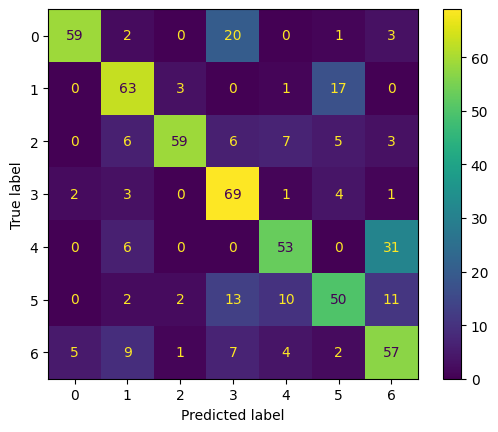

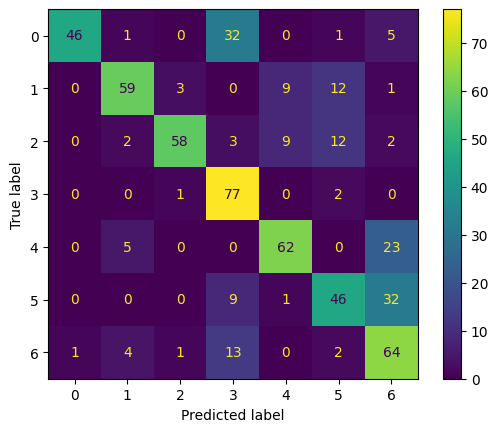

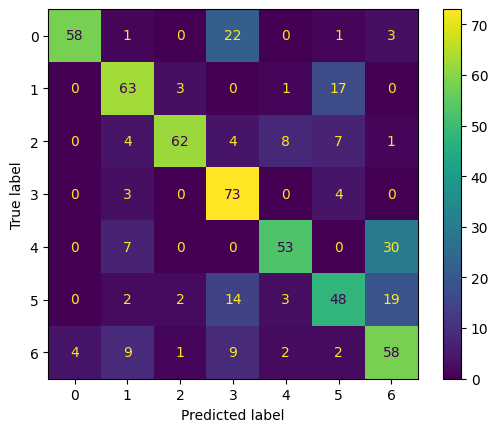

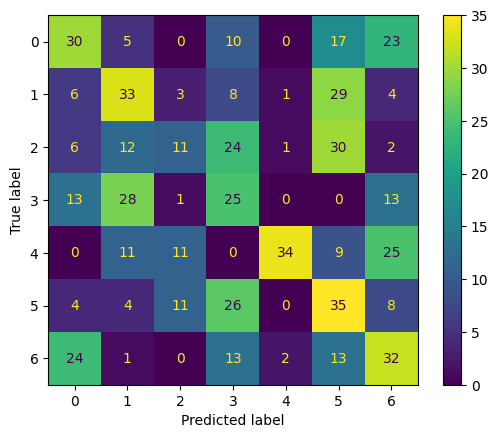

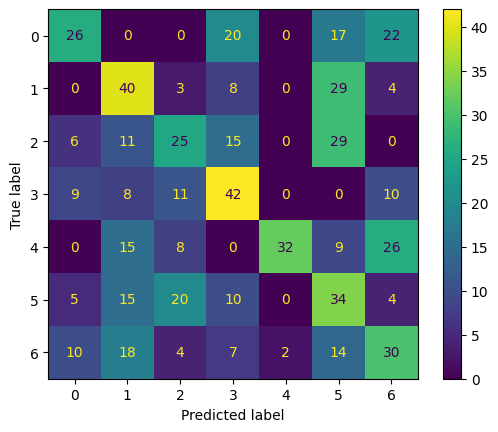

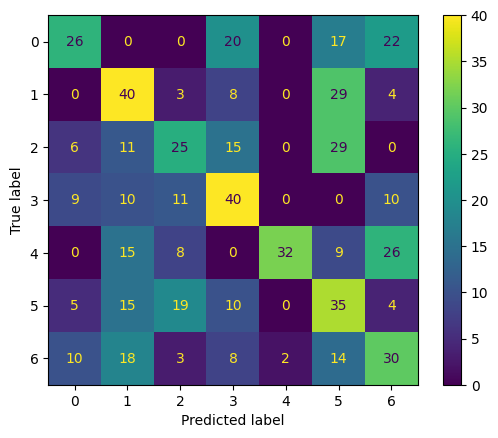

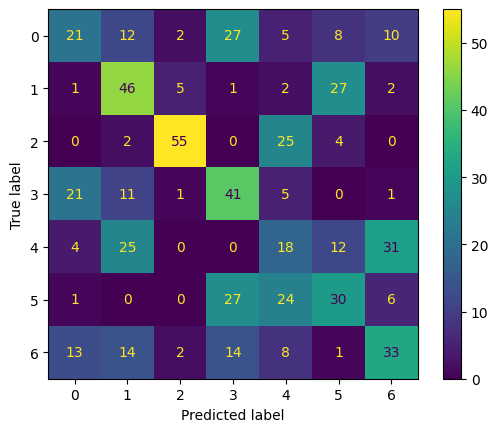

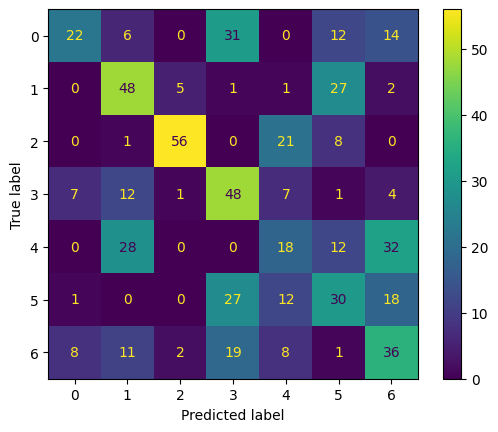

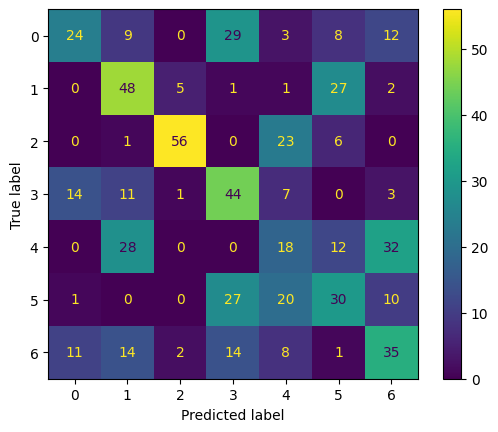

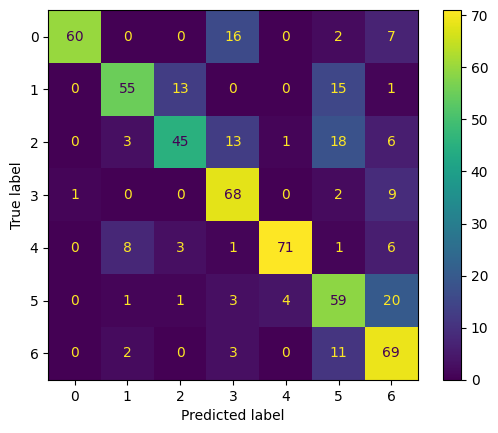

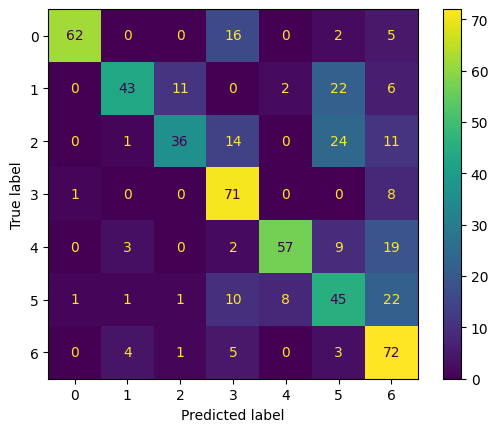

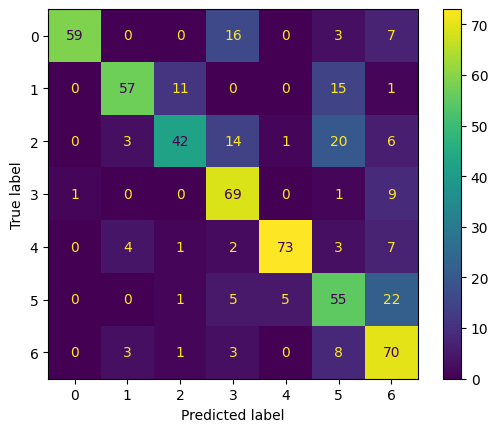

In [70]:
# 4.3

### Your code begins here ###

def combine_and_evaluate(prob1, prob2, rule_name):
    if rule_name == 'max':
        combined = np.maximum(prob1, prob2)
    elif rule_name == 'prod':
        combined = np.multiply(prob1, prob2)
    elif rule_name == 'sum':
        combined = np.add(prob1, prob2)
    else:
        raise ValueError("Invalid rule specified")
    final_predictions = np.argmax(combined, axis=1)
    f1 = metrics.f1_score(test_labels, final_predictions, average='macro')
    cm = metrics.confusion_matrix(test_labels, final_predictions)
    return f1, cm

# Evaluate each classifier combination
combinations = {
    'SVMacc+SVMdepth': (svm_acc_probs, svm_dc_probs),
    'AdaBoostacc+AdaBoostdepth': (adaboost_acc_probs, adaboost_dc_probs),
    'SVMacc+AdaBoostdepth': (svm_acc_probs, adaboost_dc_probs),
    'AdaBoostacc+SVMdepth': (adaboost_acc_probs, svm_dc_probs)
}

rules = ['max', 'prod', 'sum']

for combo_name, (prob1, prob2) in combinations.items():
    print(f"--- {combo_name} ---")
    for rule in rules:
        f1, cm = combine_and_evaluate(prob1, prob2, rule)
        print(f"Rule: {rule}, F1 Score (macro): {f1}")
        disp = metrics.ConfusionMatrixDisplay(cm)
        disp.plot()

### Your code ends here ###

# 5. Bonus task: Multimodal biometric identification of persons (optional)

<a id='task5'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 5.</b>

Can you build a classifier that recognizes the person who is performing the exercise? Use same 10 person dataset and split it so that first 25% of each long exercise sequence is used for training and rest 75% of each sequence is used for testing the classifier. Use same 5 second windowing with 3 seconds overlap to prepare the examples. Note that, now the person identity is the class label instead of exercise type. Max. 10 points are given but you can earn points from partial solution, as well.
<br>
<br>
<p> <b>5.1</b> Build a classifier to identify persons based on the features and one of the models given in task 4 (max. 5 points).</p>
<br>
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

In [20]:
# 5.1

### Your code begins here ###

#Train test dataset creation

from sklearn.model_selection import train_test_split

def train_test_select(records):
    data = records.copy()

    try:
        for i in range(len(data['df'])):
            data['df'].iloc[i].drop('time', axis=1, inplace=True)
    except Exception:
        pass

    X = data
    y = data['subject_id']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=0)

    return X_train, X_test, y_train, y_test

records_acc = df_records_windowed[df_records_windowed['sensor']=='acc']
records_dc = df_records_windowed[df_records_windowed['sensor']=='dc']

acc_train, acc_test, acc_train_label, acc_test_label = train_test_select(records_acc)
dc_train, dc_test, dc_train_label, dc_test_label = train_test_select(records_dc)

In [21]:
#Resampling ACC and DC dataset
def resample_acc_data(data):
    dfs = []
    for i in range(len(data)):
        resampled = signal.resample(data['df'].iloc[i], 125)
        resampled = resampled.reshape(3, 125)
        resampled_std_df = pd.DataFrame(scaler.fit_transform(resampled))
        #resampled_std_df['exercise_id'] = data.iloc[i]['exercise_id']
        dfs.append(resampled_std_df)
    return pd.concat(dfs, ignore_index=True)

def resample_dc_data(data):
    dfs = []
    for i in range(len(data)):
        df = data['df'].iloc[i]
        std_df = pd.DataFrame(scaler.fit_transform(df))
        #std_df['exercise_id'] = data.iloc[i]['exercise_id']
        dfs.append(std_df)
    return pd.concat(dfs, ignore_index=True)

acc_train_data = resample_acc_data(acc_train)
acc_test_data = resample_acc_data(acc_test)

dc_train_data = resample_dc_data(dc_train)
dc_test_data = resample_dc_data(dc_test)

### Your code ends here ###

In [22]:
#PCA for ACC data

pca = PCA(n_components = 10)
pca_train = pca.fit_transform(acc_train_data)
components = pca.components_
pca_test = pca.transform(acc_test_data)

def fuse_acc_data(data):
    fused_rows = []
    for i in range(0, len(data), 3):
        fused_rows.append(list(data[i]) + list(data[i+1]) + list(data[i+2]))
    return fused_rows

def add_mean_std(pca, original_data):
    mean = np.mean(original_data, axis=1)
    std = np.std(original_data, axis=1)

    pca = np.insert(pca, -1, mean.values, axis=1)
    pca = np.insert(pca, -1, std.values, axis=1)

    return pca

pca_train_mean_std = add_mean_std(pca_train, acc_train_data)
pca_test_mean_std = add_mean_std(pca_test, acc_test_data)

pca_train_fused_acc = fuse_acc_data(pca_train_mean_std)
pca_test_fused_acc = fuse_acc_data(pca_test_mean_std)

In [23]:
#PCA for DC data

pca = PCA(n_components = 10)
pca_train = pca.fit_transform(dc_train_data)
components = pca.components_
pca_test = pca.transform(dc_test_data)

def fuse_dc_data(data):
    fused_rows = []
    for i in range(0, len(data), 5):
        fused_rows.append(list(data[i]) + list(data[i+1]) + list(data[i+2]) + list(data[i+3]) + list(data[i+4]))
    return fused_rows

pca_train_fused_dc = fuse_dc_data(pca_train)
pca_test_fused_dc = fuse_dc_data(pca_test)

In [24]:
#Fuse ACC and DC PCA features

from sklearn.preprocessing import minmax_scale

def combine_pca_acc_dc(pca_acc, pca_dc):
    pca_acc_dc = [ pca_acc[i]+pca_dc[i] for i in range(len(pca_acc))]
    return pca_acc_dc

pca_train_fused_acc_dc = combine_pca_acc_dc(pca_train_fused_acc, pca_train_fused_dc)
pca_test_fused_acc_dc = combine_pca_acc_dc(pca_test_fused_acc[:-1], pca_test_fused_dc)

pca_train_norm = minmax_scale(pca_train_fused_acc_dc, feature_range=(0, 1), axis=1, copy=True)
pca_test_norm = minmax_scale(pca_test_fused_acc_dc, feature_range=(0, 1), axis=1, copy=True)

df_pca_train_norm = pd.DataFrame(pca_train_norm)
df_pca_test_norm = pd.DataFrame(pca_test_norm)

df_pca_train_norm.columns = df_pca_train_norm.columns.astype(str)
df_pca_test_norm.columns = df_pca_test_norm.columns.astype(str)

F1 score:  [0.12756264 0.13809524 0.08695652 0.07239819 0.12426036 0.09580838
 0.1779661  0.07446809 0.0877193  0.05298013]
F1 score (micro):  0.11324376199616124
F1 score (macro):  0.10382149480090001
F1 score (weighted):  0.10648966783882283
Confusion matrix: 



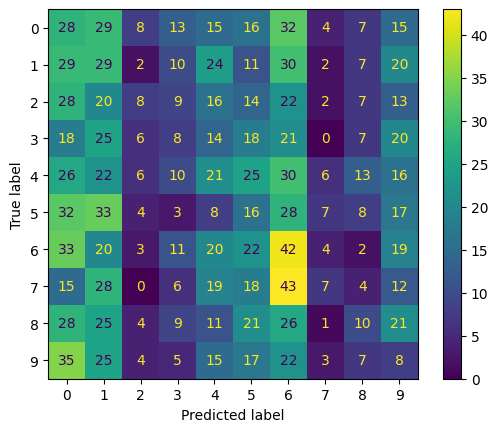

In [25]:
#SVC classifier

from sklearn.svm import SVC
clf = SVC(kernel='rbf')
clf.fit(df_pca_train_norm, dc_train_label)

predicted = clf.predict(df_pca_test_norm)

print("F1 score: ", metrics.f1_score(dc_test_label, predicted,average=None))
print("F1 score (micro): ", metrics.f1_score(dc_test_label, predicted, average='micro'))
print("F1 score (macro): ", metrics.f1_score(dc_test_label, predicted, average='macro'))
print("F1 score (weighted): ", metrics.f1_score(dc_test_label, predicted, average='weighted'))
print("Confusion matrix: \n", )
confusion_matrix = metrics.confusion_matrix(dc_test_label, predicted)
metrics.ConfusionMatrixDisplay(confusion_matrix).plot()

F1 score:  [0.10526316 0.16107383 0.01257862 0.04347826 0.19095477 0.15697674
 0.20072993 0.20151134 0.06930693 0.10045662]
F1 score (micro):  0.14779270633397312
F1 score (macro):  0.12423301923927817
F1 score (weighted):  0.12830448912871298
Confusion matrix: 



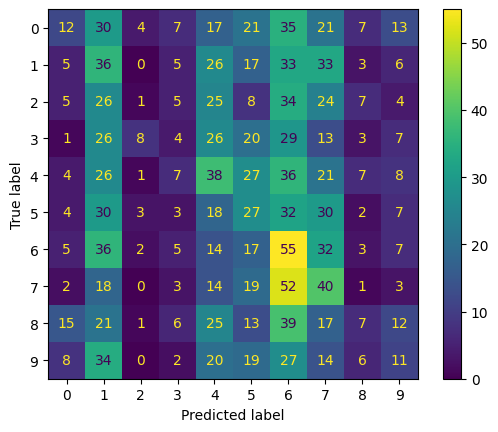

In [26]:
#GaussianNB classifier

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(df_pca_train_norm, np.ravel(dc_train_label))

predicted= gnb.predict(df_pca_test_norm)

print("F1 score: ", metrics.f1_score(dc_test_label,predicted,average=None))
print("F1 score (micro): ", metrics.f1_score(dc_test_label, predicted, average='micro'))
print("F1 score (macro): ", metrics.f1_score(dc_test_label, predicted, average='macro'))
print("F1 score (weighted): ", metrics.f1_score(dc_test_label, predicted, average='weighted'))
print("Confusion matrix: \n", )
confusion_matrix = metrics.confusion_matrix(dc_test_label,predicted)
metrics.ConfusionMatrixDisplay(confusion_matrix).plot()

<a id='task5'></a>
<div class=" alert alert-warning">

<p> <b>5.2</b> Can you build your own solution (using new features, new classification model or different fusion approaches) to beat the approach in Task 5.1 ? (max. 5 points) </p>
<br>  
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

In [ ]:
# 5.2

### Your code begins here ###

#Add exercise_id as a feature
df_pca_train_norm['exercise_id'] = dc_train['exercise_id'].values
df_pca_test_norm['exercise_id'] = dc_test['exercise_id'].values

#One-Hot encode exercise_id
df_pca_train_norm_oh = pd.get_dummies(df_pca_train_norm, columns = ['exercise_id']) 
df_pca_test_norm_oh = pd.get_dummies(df_pca_test_norm, columns = ['exercise_id']) 

df_pca_train_norm_oh.columns = df_pca_train_norm_oh.columns.astype(str)
df_pca_test_norm_oh.columns = df_pca_test_norm_oh.columns.astype(str)

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_label = le.fit_transform(dc_train_label)
test_label = le.fit_transform(dc_test_label)

xgb = XGBClassifier(n_estimators=10, max_depth=2, learning_rate=0.6, objective='multi:softprob')
xgb.fit(df_pca_train_norm_oh, train_label)
predicted = xgb.predict(df_pca_test_norm_oh)

print("F1 score: ", metrics.f1_score(test_label, predicted,average=None))
print("F1 score (micro): ", metrics.f1_score(test_label, predicted, average='micro'))
print("F1 score (macro): ", metrics.f1_score(test_label, predicted, average='macro'))
print("F1 score (weighted): ", metrics.f1_score(test_label, predicted, average='weighted'))
print("Confusion matrix: \n", )
confusion_matrix = metrics.confusion_matrix(test_label, predicted)
metrics.ConfusionMatrixDisplay(confusion_matrix).plot()

### Your code ends here ###

In [ ]:
#Hyperparameter tuning for XGBClassifier

from sklearn.model_selection import GridSearchCV

parameters = {
'max_depth':range(2,10,2),
'min_child_weight':range(2,10,2),
'gamma': [0.5, 1, 1.5, 2, 5],
#'subsample': [0.6, 0.8, 1.0],
'learning_rate': [0.7, 0.6, 0.5]
}
 
estimator = XGBClassifier(
    objective= 'multi:softprob',
    nthread=4,
    seed=42
)
 
gsearch = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=True
)
gsearch.fit(df_pca_train_norm_oh, train_label)
print("Best XGB parameters acc-dc:", gsearch.best_params_)
 
predicted = gsearch.best_estimator_.predict(df_pca_test_norm_oh)
 
print("F1 score: ", metrics.f1_score(test_label, predicted,average=None))
print("F1 score (micro): ", metrics.f1_score(test_label, predicted, average='micro'))
print("F1 score (macro): ", metrics.f1_score(test_label, predicted, average='macro'))
print("F1 score (weighted): ", metrics.f1_score(test_label, predicted, average='weighted'))
print("Confusion matrix: \n", )
confusion_matrix = metrics.confusion_matrix(test_label, predicted)
metrics.ConfusionMatrixDisplay(confusion_matrix).plot()